## Importing the required Libraries

In [4]:
import os
import numpy as np
from tqdm import tqdm
from shutil import move
import tensorflow as tf
from pathlib import Path
from random import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
train_path = Path("Data/caltech-101/101_ObjectCategories")
test_path = Path("Data/caltech-101/Test")

## Splitting into Train and Test Datasets

In [ ]:
# for folder in os.listdir(train_path):
#     if not os.path.exists(test_path / folder):
#         os.mkdir(test_path / folder)
#     files = os.listdir(train_path / folder)
#     shuffle(files)
#     for file in files[:10]:
#         move(train_path / folder / file, test_path / folder / file)

## Creating Image Data Generators

In [ ]:
train_gen = image.ImageDataGenerator(rescale=1/255.,
                                     zoom_range=.2,
                                     width_shift_range=.2,
                                     height_shift_range=.2,
                                     shear_range=.2)
test_gen = image.ImageDataGenerator(rescale=1/255.)

In [19]:
print("Training")
train_data = train_gen.flow_from_directory(train_path, batch_size=32, target_size=[150, 150], class_mode="sparse", shuffle=True)
print("Testing")
test_data = test_gen.flow_from_directory(test_path, batch_size=32, target_size=[150, 150], class_mode="sparse")

Training
Found 8124 images belonging to 102 classes.
Testing
Found 1020 images belonging to 102 classes.


In [ ]:
classes = dict([ (k, v) for v, k in train_data.class_indices.items()])

## Applying Transfer Learning
***
#### Using the weights saved by a pre-trained InceptionV3 Model and using it to create a new model

In [9]:
local_wts = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
incep = InceptionV3(include_top=False, input_shape=[150, 150, 3], weights=None)
incep.load_weights(local_wts)
for layer in incep.layers:
    layer.trainable = False

In [10]:
last_layer = incep.get_layer("mixed7")
print(last_layer.output_shape)
last_output = last_layer.output

(None, 7, 7, 768)


In [28]:
x = layers.Flatten()(last_output)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(.25)(x)
x = layers.Dense(128, activation="relu")(x)
out = layers.Dense(102, activation="softmax")(x)

model = tf.keras.models.Model(incep.input, out)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [29]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=["accuracy"])

In [30]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs/V5")

In [ ]:
model.fit(train_data, epochs=100, validation_data=test_data, callbacks=[tensorboard], verbose=0)

LOSS


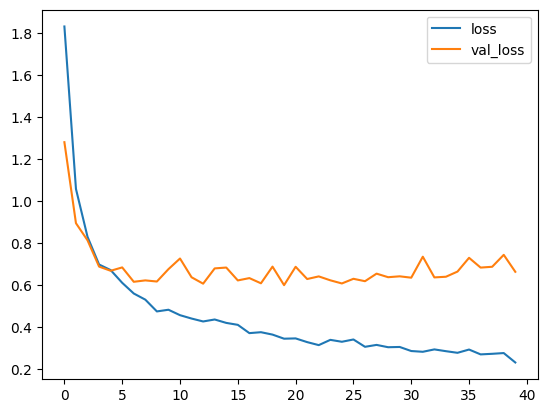

ACCURACY


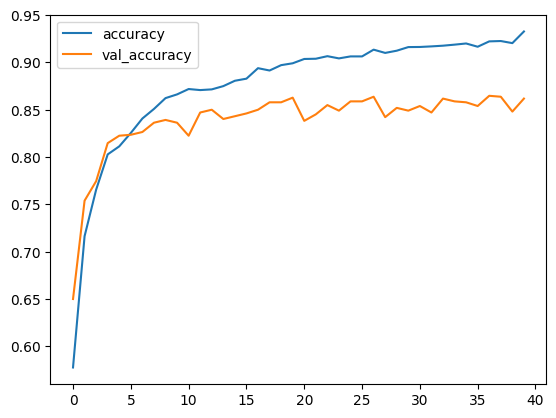

In [33]:
history = model.history
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
rng = [i for i in range(len(loss))]
print("LOSS")
plt.plot(rng, loss, label="loss")
plt.plot(rng, val_loss, label="val_loss")
plt.legend()
plt.show()
print("ACCURACY")
plt.plot(rng, acc, label="accuracy")
plt.plot(rng, val_acc, label="val_accuracy")
plt.legend()
plt.show()

In [34]:
model.evaluate(test_data)

32/32 [==============================] - 2s 51ms/step - loss: 0.6313 - accuracy: 0.8667


[0.6313002705574036, 0.8666666746139526]

In [44]:
model.save("Models/Project-2 Caltech-101-v5(0.63, 0.867).h5")